In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import yfinance as yf


In [2]:
ticker_symbol = 'AAPL'
data = yf.download(ticker_symbol, start='2010-01-01', end='2023-01-01')
data.to_csv('historical_stock_prices.csv')


[*********************100%%**********************]  1 of 1 completed


In [3]:
data = pd.read_csv('historical_stock_prices.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data.asfreq('B')
data['Close'] = data['Close'].ffill()  # Handle missing values


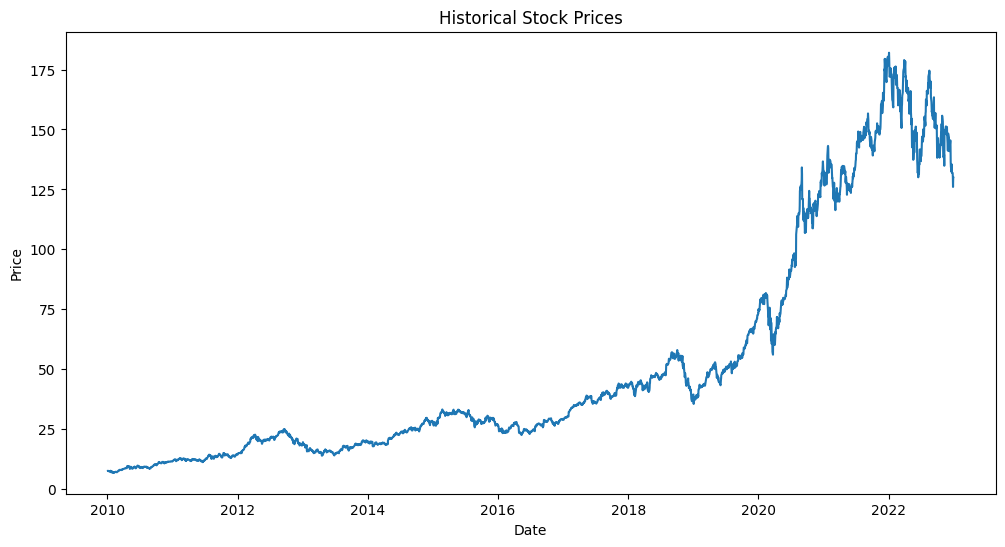

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'])
plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



In [6]:
print(data.describe())

              Open         High          Low        Close    Adj Close  \
count  3272.000000  3272.000000  3272.000000  3390.000000  3272.000000   
mean     51.297746    51.869747    50.731996    51.296440    49.065502   
std      47.328490    47.938843    46.732224    47.336212    47.433208   
min       6.870357     7.000000     6.794643     6.858929     5.798900   
25%      18.966697    19.121697    18.780179    18.973035    16.490459   
50%      29.756250    29.981250    29.561250    29.773750    27.162608   
75%      56.983748    57.309999    56.469999    56.802499    54.504441   
max     182.630005   182.940002   179.119995   182.009995   179.481110   

             Volume  
count  3.272000e+03  
mean   2.562707e+08  
std    2.225648e+08  
min    3.519590e+07  
25%    1.023541e+08  
50%    1.666698e+08  
75%    3.456643e+08  
max    1.880998e+09  


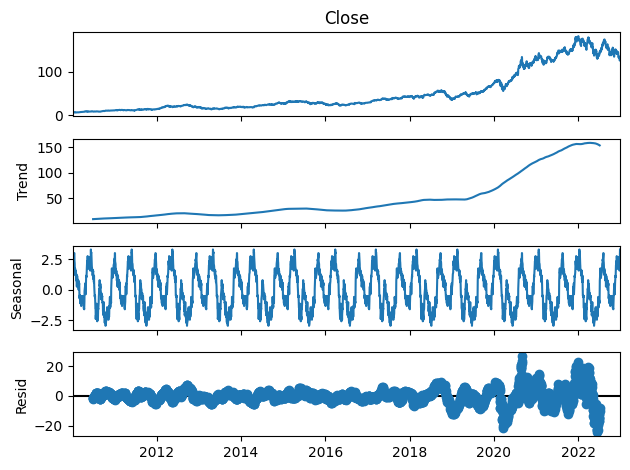

In [7]:
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)
decomposition.plot()
plt.show()


ADF Statistic: -0.27544315475089887
p-value: 0.928911026266331
ADF Statistic (Differenced): -10.201232186871396
p-value (Differenced): 5.962959500239151e-18


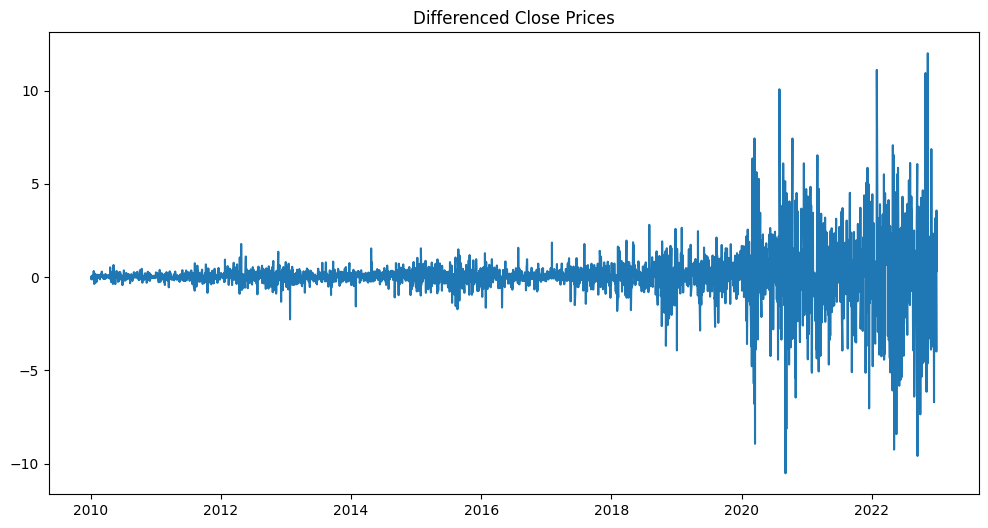

In [8]:
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
if result[1] > 0.05:
    data['Close_diff'] = data['Close'].diff().dropna()
    result = adfuller(data['Close_diff'].dropna())
    print('ADF Statistic (Differenced):', result[0])
    print('p-value (Differenced):', result[1])
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close_diff'])
    plt.title('Differenced Close Prices')
    plt.show()


In [10]:
model = ARIMA(data['Close'], order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())




                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3390
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5891.552
Date:                Mon, 03 Jun 2024   AIC                          11795.103
Time:                        21:05:15   BIC                          11831.873
Sample:                    01-04-2010   HQIC                         11808.247
                         - 12-30-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0620      0.008     -8.056      0.000      -0.077      -0.047
ar.L2         -0.0364      0.008     -4.305      0.000      -0.053      -0.020
ar.L3         -0.0298      0.008     -3.625      0.0

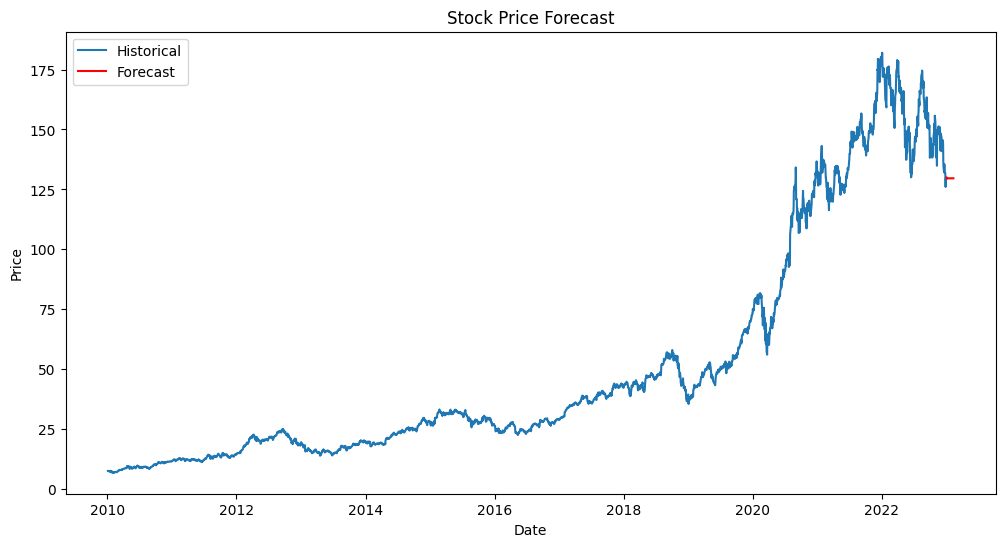

In [11]:
forecast = model_fit.forecast(steps=30)
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Historical')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

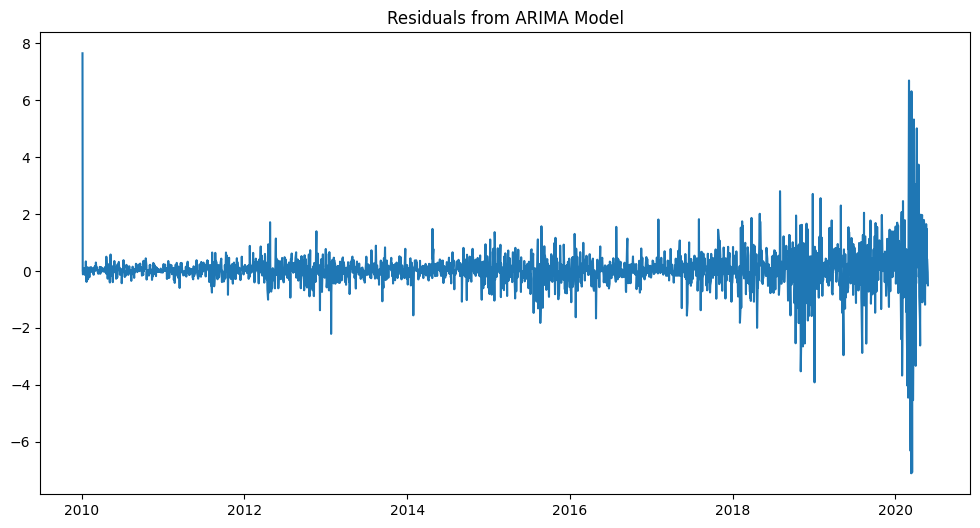

In [15]:
residuals = model_fit.resid
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()




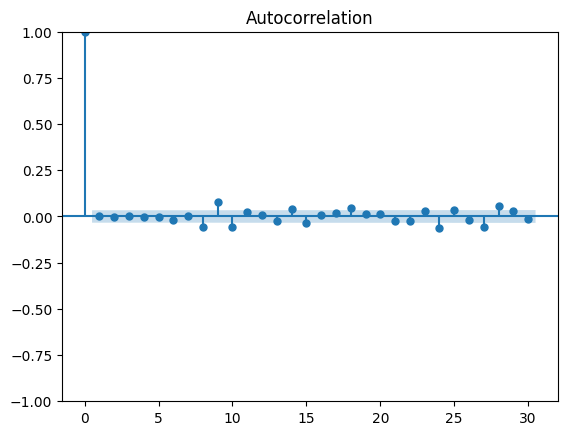

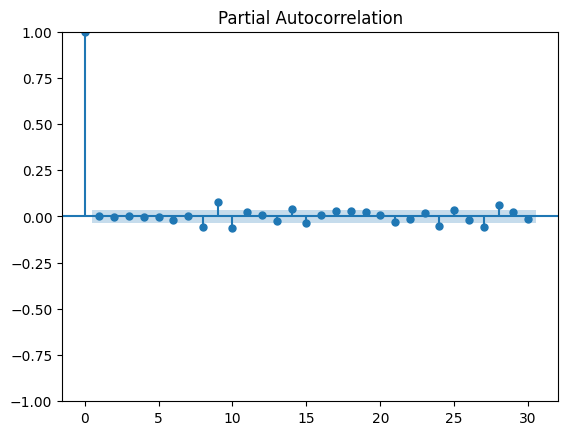

Root Mean Squared Error: 63.751050920884246


In [14]:
plot_acf(residuals, lags=30)
plot_pacf(residuals, lags=30)
plt.show()



In [16]:
rmse = np.sqrt(mean_squared_error(data['Close'][-len(forecast):], forecast))
print('Root Mean Squared Error:', rmse)

Root Mean Squared Error: 63.751050920884246


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2712
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2670.456
Date:                Mon, 03 Jun 2024   AIC                           5352.911
Time:                        21:06:01   BIC                           5388.342
Sample:                    01-04-2010   HQIC                          5365.721
                         - 05-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1698      0.007    -24.166      0.000      -0.184      -0.156
ar.L2          0.0222      0.006      3.704      0.000       0.010       0.034
ar.L3          0.0108      0.007      1.449      0.1

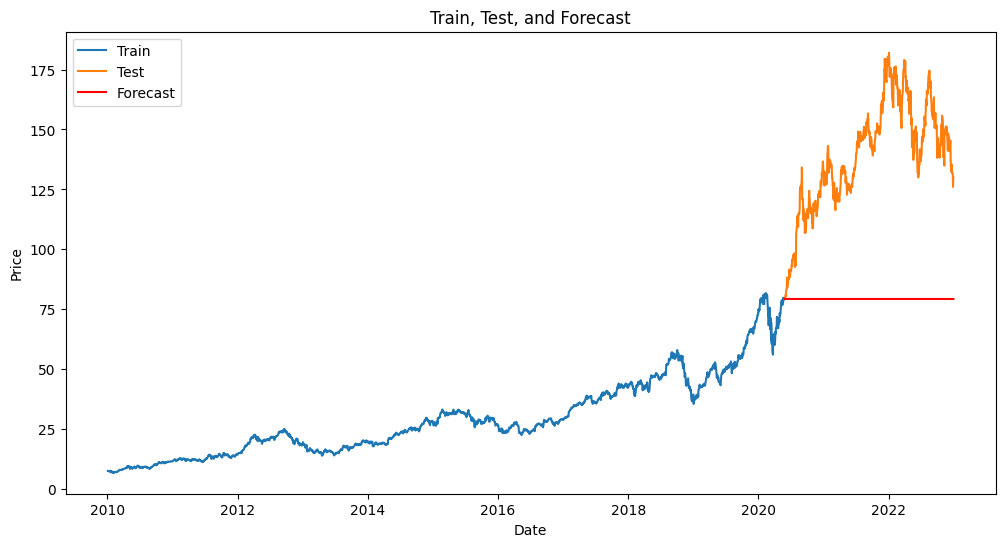

Test RMSE: 63.751050920884246


In [13]:
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]

model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(test, forecast))
print('Test RMSE:', rmse)
